In [1]:
import os
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"
print(os.environ.get("HSA_OVERRIDE_GFX_VERSION"))
# del x_gpu, y_gpu
# torch.cuda.empty_cache()

11.0.0


# Library

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Load data


In [3]:
image_size = 128

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.image_filenames = [f for f in os.listdir(img_dir)]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load và convert sang grayscale
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)

        # Gán label từ tên file (giả sử ký tự đầu là nhãn)
        label = int(img_name[0])
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


# Compute mean and std for dataset

In [4]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=12)
    mean = 0.0
    std = 0.0
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std

transform_no_norm = v2.Compose([
    v2.Resize((image_size, image_size)),
    v2.ToImage(),  # Chuyển PIL Image -> tensor
    v2.ToDtype(torch.float32, scale=True),  # Scale từ [0,255] -> [0,1] 
])

train_data = CustomImageDataset(
    img_dir=r"/home/lineage/Desktop/Image Classification/TrainImages",
    transform=transform_no_norm
)

mean, std = compute_mean_std(train_data)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.6595]), Std: tensor([0.0709])


In [5]:
def equalize(img):
    return ImageOps.equalize(img)

transform = v2.Compose([
    v2.RandomRotation(10),
    v2.Resize((image_size, image_size)),  # Resize sau khi ảnh đã được center
    v2.Lambda(equalize),
    v2.ToImage(),  # Chuyển PIL Image -> tensor
    v2.ToDtype(torch.float32, scale=True),  # Scale từ [0,255] -> [0,1] 
    v2.Normalize(mean=(mean,), std=(std,)),
])

test_transform = v2.Compose([
    v2.Resize((image_size, image_size)),  # Resize sau khi ảnh đã được center
    v2.Lambda(equalize),
    v2.ToImage(),  # Chuyển PIL Image -> tensor
    v2.ToDtype(torch.float32, scale=True),  # Scale từ [0,255] -> [0,1] 
    v2.Normalize(mean=(mean,), std=(std,)),
])

train_data = CustomImageDataset(img_dir=r"/home/lineage/Desktop/Image Classification/TrainImages", transform=transform)
test_data = CustomImageDataset(img_dir=r"/home/lineage/Desktop/Image Classification/TestImages", transform=test_transform)

train_dataloader = DataLoader(train_data, batch_size=64, num_workers=12, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, num_workers=12, shuffle=False)

# Show data

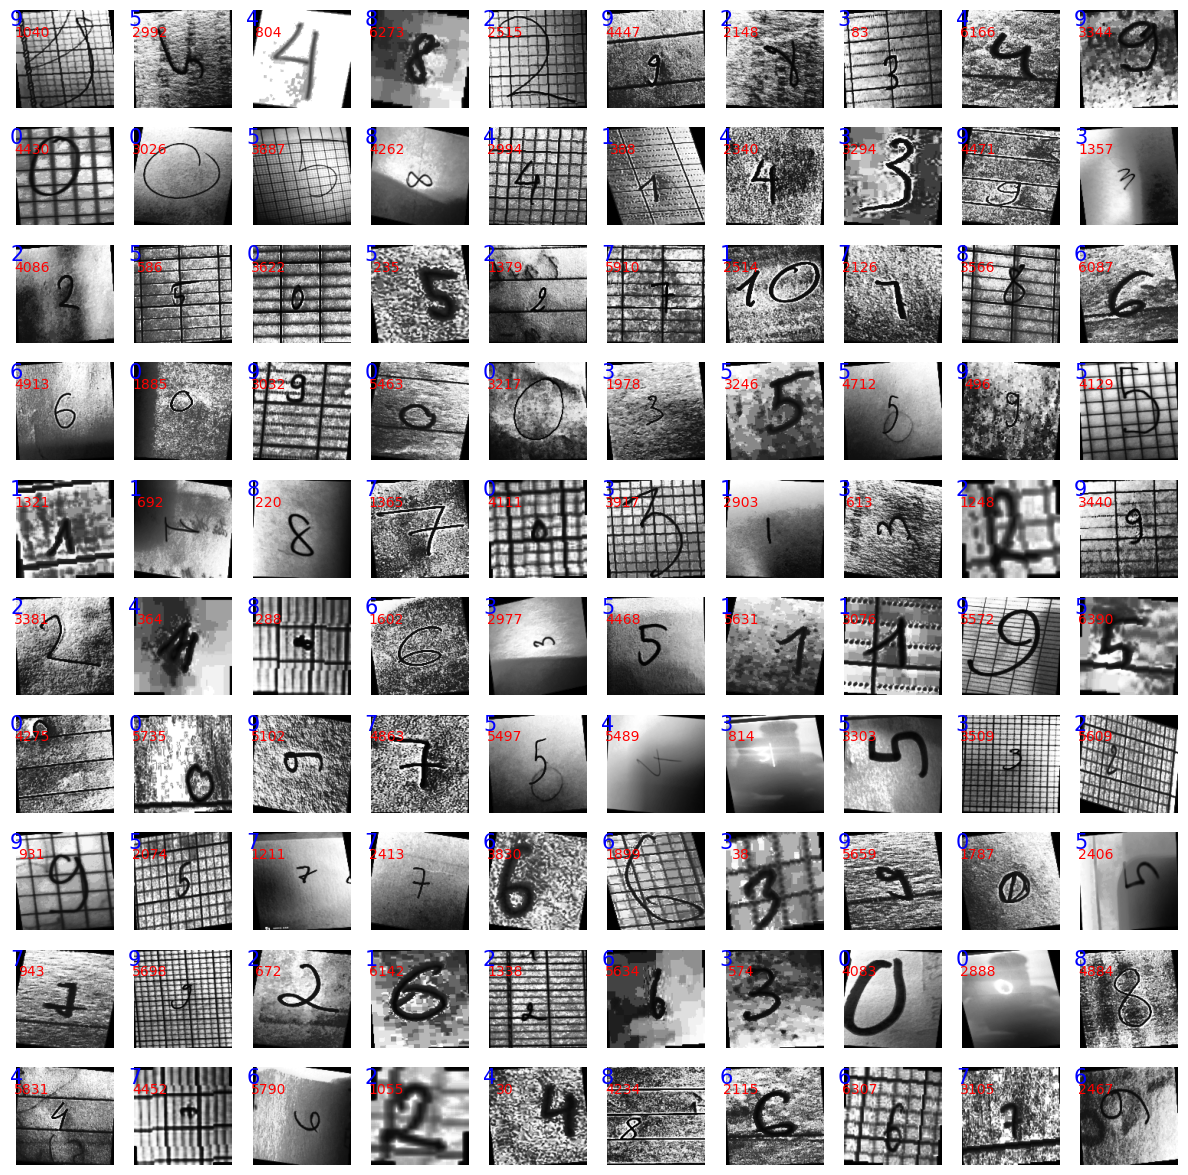

In [6]:
figure = plt.figure(figsize=(15, 15))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.text(0, 0, str(label),
            ha="center", va="top", fontsize=15, color="blue")
    plt.text(20, 20, str(sample_idx),
            ha="center", va="top", fontsize=10, color="red")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Model

In [8]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(image_size*image_size, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
            
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
            
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), #1 128 128 -> 32 128 128
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #32 128 128 -> 32 64 64

            nn.Conv2d(32, 64, 3, padding=1), #32 64 64 -> 64 64 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64 64 64 -> 64 32 32
            
            nn.Conv2d(64, 128, 3, padding=1), #64 32 32 -> 128 32 32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #128 16 16
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Use GPU to compute

In [9]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

model = CNN().to(device)

print(model)
print(next(model.parameters()).device)


Using cuda device
CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=256, bias=True)
    (2): BatchNo

# Training

In [10]:
learning_rate = 1e-4
batch_size = 64

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Move data to the device
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

best_correct = 0.0
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Move data to the device
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    global best_correct
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if correct > best_correct:
            best_correct = correct
            torch.save(model.state_dict(), 'best_model.pth')
            print('SAVED!')

In [11]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.440104  [   64/ 6414]
loss: 2.398337  [ 1344/ 6414]
loss: 2.237590  [ 2624/ 6414]
loss: 2.181014  [ 3904/ 6414]
loss: 2.195220  [ 5184/ 6414]
loss: 2.098712  [ 6414/ 6414]
Test Error: 
 Accuracy: 28.5%, Avg loss: 2.077143 

SAVED!
Epoch 2
-------------------------------
loss: 2.020318  [   64/ 6414]
loss: 2.058666  [ 1344/ 6414]
loss: 1.981026  [ 2624/ 6414]
loss: 1.779447  [ 3904/ 6414]
loss: 1.726351  [ 5184/ 6414]
loss: 1.856091  [ 6414/ 6414]
Test Error: 
 Accuracy: 39.8%, Avg loss: 1.783483 

SAVED!
Epoch 3
-------------------------------
loss: 1.683484  [   64/ 6414]
loss: 1.601770  [ 1344/ 6414]
loss: 1.569248  [ 2624/ 6414]
loss: 1.655259  [ 3904/ 6414]
loss: 1.408629  [ 5184/ 6414]
loss: 1.736178  [ 6414/ 6414]
Test Error: 
 Accuracy: 53.2%, Avg loss: 1.547538 

SAVED!
Epoch 4
-------------------------------
loss: 1.364506  [   64/ 6414]
loss: 1.360075  [ 1344/ 6414]
loss: 1.225334  [ 2624/ 6414]
loss: 1.308929  [ 3904/ 6414]
los

KeyboardInterrupt: 